In [1]:
import awk_data
import awkward as ak
import tensorflow as tf
import loader
import argparse 
from collections import defaultdict
import os, json
import importlib.util
from time import time
import numpy as np
from plotting import * 
import plot_loss


model_file = "models_archive/model_onlytransformer.py"
config_json = "training_config/training_run3_transformer/training_run3_transformer_v1.json" 

2024-04-18 13:32:18.687781: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-18 13:32:18.942646: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load the model and dataset

In [2]:
config = json.load(open(config_json))

config['activation'] = tf.keras.activations.get(config['activation'])

# Checking hardware
print('version={}, CUDA={}, GPU={}'.format(
    tf.__version__, tf.test.is_built_with_cuda(),
    len(tf.config.list_physical_devices('GPU')) > 0))
      
gpus =  tf.config.list_physical_devices('GPU')

# if len(gpus) ==1 :
#     print("Using 1 GPU")
#     tf.config.experimental.set_memory_growth(gpus[0], enable=True)
#     strategy = tf.distribute.OneDeviceStrategy("gpu:0")
# elif len(gpus):
#     print("Using {} GPUs".format(len(gpus)))
#     for gpu in gpus:
#         tf.config.experimental.set_memory_growth(gpu, enable=True)
#     strategy = tf.distribute.MirroredStrategy()
# else:
#     strategy = tf.distribute.OneDeviceStrategy("cpu:0")
if len(gpus) >=1 :
    print("Using 1 GPU")
    #tf.config.experimental.set_memory_growth(gpus[0], enable=True)
    strategy = tf.distribute.OneDeviceStrategy("gpu:0")
else:
    strategy = tf.distribute.OneDeviceStrategy("cpu:0")


##################
# Prepare the output folder
def get_unique_run():
    previous_runs = os.listdir(config["models_path"])
    if len(previous_runs) == 0:
        run_number = 1
    else:
        run_number = max([int(s.split('run_')[1]) for s in previous_runs]) + 1
    return run_number

if not os.path.isdir(config["models_path"]):
    os.makedirs(config["models_path"])

name =  'run_{:02}'.format(get_unique_run())

outdir = config["models_path"] + "/"+ name

if os.path.isdir(outdir):
    print("Output directory exists: {}".format(outdir), file=sys.stderr)
else:
    os.makedirs(outdir)

print("Model output folder: ", outdir)

############################3
#Copying the config file and model file in the output dir:
os.system("cp {} {}".format(config_json, outdir))
os.system("cp {} {}".format(model_file, outdir))

###########################
## Loading the datasets
print(">>> Loading datasets")

train_ds = awk_data.load_dataset(awk_data.LoaderConfig(**config["dataset_conf"]["training"]))
test_ds = awk_data.load_dataset(awk_data.LoaderConfig(**config["dataset_conf"]["validation"]))
# Create training and validation
ds_train = train_ds.prefetch(tf.data.AUTOTUNE).repeat(config['nepochs'])
ds_test  = test_ds.prefetch(tf.data.AUTOTUNE).repeat(config['nepochs'])

2024-04-18 13:32:28.595794: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-18 13:32:28.623689: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-18 13:32:28.623918: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

version=2.13.1, CUDA=True, GPU=True
Using 1 GPU
Model output folder:  /eos/user/d/dvalsecc/www/ECAL/Clustering/DeepCluster/models_archive/gcn_models/Run3_126X_2023/tests_transformer//run_32
>>> Loading datasets


In [3]:
############### 
# Loading the model file
 # Load model modules
spec = importlib.util.spec_from_file_location("model", model_file)
model_lib = importlib.util.module_from_spec(spec)
spec.loader.exec_module(model_lib)

tf.keras.backend.clear_session()
# Construction of the model in the strategy scope
with strategy.scope():
    print(">>> Creating the model")
    # Build the model with all the configs
    model = model_lib.DeepClusterTransformer(**config)

    #optimizer
    if config['opt'] == "adam":
        opt = tf.keras.optimizers.Adam(learning_rate=config['lr'])

    #compile the model
    model.compile(optimizer=opt)
    model.set_metrics()

    for X, y ,w  in ds_train:
        # Load the model
        ypred = model(X, training=False)
        #l = custom_loss(y, ypred)
        break

    model.summary()
    

>>> Creating the model


2024-04-18 13:32:41.537092: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


Model: "deep_cluster_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 features_builder (Features  multiple                  68792     
 Building)                                                       
                                                                 
 global_transformer_0 (Mult  multiple                  38560     
 iSelfAttentionBlock)                                            
                                                                 
 global_transformer_1 (Mult  multiple                  38560     
 iSelfAttentionBlock)                                            
                                                                 
 global_transformer_2 (Mult  multiple                  38560     
 iSelfAttentionBlock)                                            
                                                                 
 global_transformer_3 (Mult  multiple     

## Evaluating the model

In [6]:
X, ytrue, w = next(iter(ds_train))

In [7]:
ypred = model(X)

In [11]:
tf.sigmoid(ypred[0][0])

<tf.Tensor: shape=(512, 17, 1), dtype=float32, numpy=
array([[[0.6018201 ],
        [0.5       ],
        [0.5       ],
        ...,
        [0.5       ],
        [0.5       ],
        [0.5       ]],

       [[0.56032187],
        [0.4504264 ],
        [0.34918898],
        ...,
        [0.5       ],
        [0.5       ],
        [0.5       ]],

       [[0.7257393 ],
        [0.53276527],
        [0.5       ],
        ...,
        [0.5       ],
        [0.5       ],
        [0.5       ]],

       ...,

       [[0.75059336],
        [0.5685579 ],
        [0.5       ],
        ...,
        [0.5       ],
        [0.5       ],
        [0.5       ]],

       [[0.48063752],
        [0.3287788 ],
        [0.5       ],
        ...,
        [0.5       ],
        [0.5       ],
        [0.5       ]],

       [[0.59520024],
        [0.4371318 ],
        [0.5849209 ],
        ...,
        [0.5       ],
        [0.5       ],
        [0.5       ]]], dtype=float32)>

# Check losses

### Classification loss

In [13]:
(dense_clclass, dense_windclass, en_regr_factor),  mask_cls  = ypred
y_clclass, y_windclass, cl_X, wind_X, y_metadata = ytrue        
class_loss = tf.keras.losses.binary_crossentropy(y_clclass[:,:,tf.newaxis], dense_clclass, from_logits=True) * mask_cls
# This should be replaced by the mean over the not masked elements
reduced_loss = tf.reduce_sum(tf.reduce_mean(class_loss, axis=-1) * w) / tf.reduce_sum(w)
# reduced_loss = tf.reduce_sum(tf.reduce_sum(class_loss, axis=-1) * weight / tf.reduce_sum) / tf.reduce_sum(weight)

In [14]:
%%timeit
class_loss*mask_cls

49.5 µs ± 776 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [15]:
old_loss = tf.reduce_mean(class_loss, axis=-1)
correct_loss = tf.reduce_sum(class_loss, axis=-1) / tf.reduce_sum(mask_cls, axis=-1)
ncls = tf.reduce_sum(mask_cls, axis=-1)

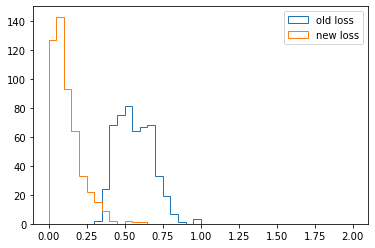

In [16]:
plt.hist(correct_loss, bins=40, range=(0,2), histtype="step", label="old loss")
plt.hist(old_loss, bins=40, range=(0,2), histtype="step", label="new loss")
plt.legend()

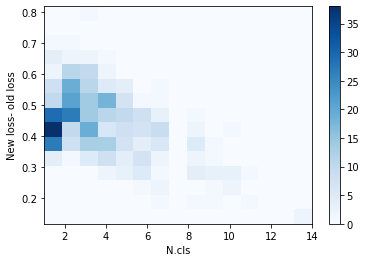

In [17]:
plt.hist2d(ncls, correct_loss- old_loss, bins=15, cmap="Blues")
plt.xlabel('N.cls')
plt.ylabel("New loss- old loss")
plt.colorbar()

### SoftF1 classification loss

In [18]:
(dense_clclass, dense_windclass, en_regr_factor), mask_cls  = ypred
y_clclass, y_windclass, cl_X, wind_X, y_metadata = ytrue
y_target = tf.cast(y_clclass, tf.float32)[:,:,tf.newaxis]
beta = 1.5
# matched_window = tf.cast(y_metadata[:,-1]!=0, tf.float32)

pred_prob = tf.nn.sigmoid(dense_clclass)*mask_cls[:,:,None]
tp = tf.reduce_sum(pred_prob * y_target, axis=1)
fn = tf.reduce_sum((1 - pred_prob) * y_target, axis=1)
fp = tf.reduce_sum(pred_prob * (1 - y_target), axis=1)

soft_f1_loss = 1 - ((1 + beta**2) * tp)/ ( (1+beta**2)*tp + beta* fn + fp + 1e-16) 
reduced_f1 = tf.reduce_sum(tf.squeeze(soft_f1_loss) * w) / tf.reduce_sum(w) 

In [19]:
reduced_f1

<tf.Tensor: shape=(), dtype=float32, numpy=0.39589062>

In [20]:
reduced_f1

<tf.Tensor: shape=(), dtype=float32, numpy=0.39589062>

### Energy losses

In [21]:
(dense_clclass, dense_windclass, en_regr_factor), mask_cls  = ypred
y_clclass, y_windclass, cl_X, wind_X, y_metadata = ytrue
y_target = tf.cast(y_clclass, tf.float32)[:,:,tf.newaxis]
cl_en = Et = cl_X[:,:,0:1]
En_sim_good = y_metadata[:,-1]
pred_prob = tf.nn.sigmoid(dense_clclass)*mask_cls[:,:,None] ### Masking???

sel_en = tf.squeeze(tf.reduce_sum(cl_en * pred_prob , axis=1))
en_resolution_loss =  tf.reduce_sum(tf.square( (sel_en/En_sim_good) - 1) * w ) / tf.reduce_sum(w) 

In [22]:
pred_prob = tf.nn.sigmoid(dense_clclass)

In [23]:
sel_en[0:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([ 780.512   ,  280.5111  , 1268.4597  ,  242.13467 ,  220.26003 ,
        541.4424  ,  462.88995 , 1295.6138  ,   31.044123,  546.56976 ],
      dtype=float32)>

In [24]:
sel_en[0:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([ 780.512   ,  280.5111  , 1268.4597  ,  242.13467 ,  220.26003 ,
        541.4424  ,  462.88995 , 1295.6138  ,   31.044123,  546.56976 ],
      dtype=float32)>

## Training

In [25]:
import tensorflow_model_optimization as tfmot
initial_sparsity = 0.0
final_sparsity = 0.75
begin_step = 200
end_step = 300
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=initial_sparsity,
        final_sparsity=final_sparsity,
        begin_step=begin_step,
        end_step=end_step)
}

In [10]:
model = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)
pruning_callback = tfmot.sparsity.keras.UpdatePruningStep()

ValueError: `prune_low_magnitude` can only prune an object of the following types: tf.keras.models.Sequential, tf.keras functional model, tf.keras.layers.Layer, list of tf.keras.layers.Layer. You passed an object of type: DeepClusterGN.